In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import pandas
from keras import Sequential
from keras.datasets import mnist
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.utils import np_utils, to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Input
from keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn import metrics as me

In [3]:
from enum import Enum

class Label(Enum):
    COFFEE = 0
    NATIVEVEGE = 1
    URBAN = 2
    WATER = 3
    PEPPER = 4
    TEA = 5
    
class Band(Enum):
    COASTAL_AEROSOL = 0
    BLUE = 1
    GREEN = 2
    RED = 3
    NIR = 4
    SWIR1 = 5
    SWIR2 = 6
    PANCHROMATIC = 7
    CIRRUS = 8
    TIRS1 = 9
    TIRS2 = 10

In [4]:
IMAGE_WIDTH = 9
IMAGE_HEIGHT = 9
IMAGE_DEPTH = 3
NB_LABELS = 6
BANDS = [Band.BLUE.value, Band.RED.value, Band.NIR.value]
TRAIN_TEST_RATIO = 0.8
EPOCHS = 100

In [5]:
# Adapated from split_dataset of MLG course
def split_dataset(dataset, train_test_ratio=0.8):
    np.random.shuffle(dataset)
    nb_train = int(len(dataset) * TRAIN_TEST_RATIO)
    return (dataset[:nb_train], dataset[nb_train:])

# This function generates a colored confusion matrix.
# Adapted from plot_confusion_matrix of MLG course
def plot_confusion_matrix(confmat, labels_names, ax=None):
    if ax is None:
        ax = plt.subplot(111)
    cmim = ax.matshow(confmat, interpolation='nearest', cmap=plt.cm.Blues)

    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.annotate(str(confmat[i, j]), xy=(j, i),
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=8)
    ax.set_xticks(np.arange(confmat.shape[0]))
    ax.set_xticklabels([labels_names[l] for l in range(confmat.shape[0])], rotation='vertical')
    ax.set_yticks(np.arange(confmat.shape[1]))
    _ = ax.set_yticklabels([labels_names[l] for l in range(confmat.shape[1])])
    ax.set_xlabel('predicted label')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('true label')
    #plt.colorbar(cmim, shrink=0.7, orientation='horizontal', pad=0.01)
    
def images_from_dataset(dataset):
    return np.array([
        [
            [
                [
                    img['image'][band][row][col]
                    for band in BANDS
                ] for col in range(IMAGE_WIDTH)
            ] for row in range(IMAGE_HEIGHT)
        ] for img in dataset
    ])

def labels_from_dataset(dataset):
    return np.array([Label[img['label']].value for img in dataset])

In [6]:
dataset = []

with open('dataset.json', 'r') as f:
    dataset = json.load(f)

(train, test) = split_dataset(dataset)

X_train = images_from_dataset(train)
y_train = labels_from_dataset(train)
Y_train = to_categorical(y_train, num_classes=NB_LABELS)

X_test = images_from_dataset(test)
y_test = labels_from_dataset(test)
Y_test = to_categorical(y_test, num_classes=NB_LABELS)

# Compute nb of occurences by labels
# np.sum(np.vstack((y_train, y_test)), axis=0)

In [7]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [8]:
inputs = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH))

# Add layers of convolution and pooling
model_layers = Rescaling(1./(2**16))(inputs)
model_layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(model_layers)
model_layers = Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu")(model_layers)
model_layers = MaxPooling2D(pool_size=(3, 3))(model_layers)
model_layers = Conv2D(filters=8, kernel_size=(2, 2), padding="same", activation="relu")(model_layers)
model_layers = Conv2D(filters=4, kernel_size=(2, 2), padding="same", activation="relu")(model_layers)
model_layers = Flatten(name='flat')(model_layers)
model_layers = Dense(256, activation='relu')(model_layers)
model_layers = Dropout(0.5)(model_layers)
outputs = Dense(NB_LABELS, activation='softmax')(model_layers)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9, 9, 3)]         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 9, 9, 3)           0         
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 32)          896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 16)          4624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 8)           520       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 4)           132   

In [9]:
# Specify optimizer and loss function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
data_gen_args = dict(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# create data generator
datagen = ImageDataGenerator(**data_gen_args)
datagen.fit(X_train)
train_datagen = datagen.flow(X_train, Y_train, batch_size=32)
#class_weights = class_weight.compute_class_weight('balanced', np.unique(train_datagen.classes), train_datagen.classes)

In [11]:
history = model.fit(train_datagen, validation_data=(X_test, Y_test), class_weight=class_weights, steps_per_epoch=len(y_train) / 32, epochs=EPOCHS)

Epoch 1/100
230/230 [==============================] - 2s 7ms/step - loss: 1.7401 - accuracy: 0.1864 - val_loss: 1.4344 - val_accuracy: 0.3467
Epoch 2/100
230/230 [==============================] - 1s 6ms/step - loss: 1.4499 - accuracy: 0.3176 - val_loss: 1.3795 - val_accuracy: 0.3641
Epoch 3/100
230/230 [==============================] - 1s 6ms/step - loss: 1.3450 - accuracy: 0.3707 - val_loss: 1.2589 - val_accuracy: 0.4286
Epoch 4/100
230/230 [==============================] - 1s 6ms/step - loss: 1.3006 - accuracy: 0.3635 - val_loss: 1.2622 - val_accuracy: 0.3527
Epoch 5/100
230/230 [==============================] - 1s 6ms/step - loss: 1.2538 - accuracy: 0.3668 - val_loss: 1.2071 - val_accuracy: 0.3966
Epoch 6/100
230/230 [==============================] - 1s 6ms/step - loss: 1.2212 - accuracy: 0.3966 - val_loss: 1.1836 - val_accuracy: 0.4466
Epoch 7/100
230/230 [==============================] - 1s 6ms/step - loss: 1.1732 - accuracy: 0.4325 - val_loss: 1.2182 - val_accuracy: 0.4352

Epoch 58/100
230/230 [==============================] - 1s 6ms/step - loss: 0.9095 - accuracy: 0.5848 - val_loss: 0.9813 - val_accuracy: 0.6082
Epoch 59/100
230/230 [==============================] - 1s 6ms/step - loss: 0.9072 - accuracy: 0.5764 - val_loss: 1.0291 - val_accuracy: 0.5779
Epoch 60/100
230/230 [==============================] - 1s 6ms/step - loss: 0.9022 - accuracy: 0.5722 - val_loss: 0.9884 - val_accuracy: 0.5996
Epoch 61/100
230/230 [==============================] - 1s 6ms/step - loss: 0.8902 - accuracy: 0.5755 - val_loss: 1.0118 - val_accuracy: 0.5849
Epoch 62/100
230/230 [==============================] - 1s 6ms/step - loss: 0.9227 - accuracy: 0.5561 - val_loss: 1.0485 - val_accuracy: 0.5893
Epoch 63/100
230/230 [==============================] - 1s 6ms/step - loss: 0.9107 - accuracy: 0.5798 - val_loss: 0.9832 - val_accuracy: 0.6093
Epoch 64/100
230/230 [==============================] - 1s 6ms/step - loss: 0.9213 - accuracy: 0.5743 - val_loss: 1.0409 - val_accuracy:

In [12]:
#history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), class_weight=class_weights, batch_size=32, epochs=500)

Test score: 0.9902510046958923
Test accuracy: 0.6082473993301392


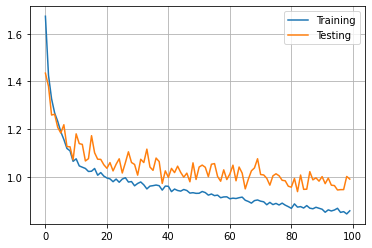

In [13]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [14]:
pred = model.predict_on_batch(X_test)
pred = np.argmax(pred, axis=-1)

confusion_matrix = me.confusion_matrix(y_test, pred)
plot_confusion_matrix(confusion_matrix, classes)

NameError: name 'classes' is not defined

In [ ]:
classes = [label.name for label in [Label.COFFEE, Label.NATIVEVEGE, Label.URBAN, Label.WATER, Label.PEPPER, Label.TEA]]
 
print(me.classification_report(y_test, pred, target_names=classes))